# Notebook that computes Shapiro delay from galaxy cluster catalogs

Written for Python2 (2.7.12). 

Authors: Olivier Minazzoli

Date (yymmdd): 190722

This code generates the results in TABLE I and the plots in FIG. 2 of the manuscript LIGO-P1900149

Code tested with matplotlib 2.1.2, 2.2.3 and 2.2.4. Plotting issues were found with version 1.5.1.

## References

- [Teyssandier and Le Poncin-Lafitte 2008]: http://adsabs.harvard.edu/abs/2008CQGra..25n5020T
- [Tempel et al. 2016]: http://adsabs.harvard.edu/abs/2016A%26A...588A..14T
- [Tully 2015]: http://adsabs.harvard.edu/abs/2015AJ....149..171T
- [Abbott et al 2017]: http://adsabs.harvard.edu/abs/2017ApJ...848L..13A

## Inputs of the code

- 'file_names.in': File with the names of all the data files to be called (file in local folder)

1/ From GW and counterpart data

- File with the position of the source of the gravitational waves [right ascension (deg), declination (deg), distance (Mpc)] (nomenclature eg. 'RA_DEC.dat' or 'NGC4993.dat')  (file in local folder 'events_data')


2/ From catalog of galaxy cluster (eg. [Tempel et al. 2016], or [Tully 2015]) 

- File with postions from a catalog of the sources of the gravitational potentials in which the wave is traveling [right ascension (deg), declination (deg), distance (Mpc)] (nomenclature eg. 'Tempel2016.dat') (file in local folder 'catalogs_data')

# Code

In [1]:
# Import scientific package numpy
import numpy as np
#Import I/O packages
from io import BytesIO
# Import package to deal with astronomical coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
# Import plotting package
import matplotlib.pyplot as plt  
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Import constants from LAL 
from lal import PC_SI, C_SI, G_SI, MSUN_SI

In [3]:
# Import package to deal with uncertainties
from uncertainties import ufloat
from uncertainties.umath import * #Import math functions that can handle uncertainties e.g. sin()
from uncertainties import unumpy  #Import tools for array manipulation

In [4]:
import sys # in order to use sys.exit("Error message")

## Data extraction and setup

In [5]:
# Read the file where the data file names are stored
file_names = np.genfromtxt('file_names.in', dtype='string', comments = '#')

### Read file that gives the position of the source of the GWs

In [6]:
# Define name of file to be called
position = file_names[2]   # must be in 'events_data/%s.dat' 

#Read the file where the characteristics of the source of the event is given: ra, dec, distance (Mpc), Mass
source = np.genfromtxt('events_data/%s.dat' % position, comments = '#')

sourceRA = source[0]             # RA coordinate of the source (deg)
sourceDEC = source[1]            # DEC coordinate of the source (deg)
sourceDIS = source[2]            # Distance of the source (Mpc)

### Read the catalogs of the gravitational sources and concatenate them

In [7]:
# Define name of file to be called
catalog = file_names[3]   # must be in 'catalogs_data/%s.dat' 

# Read the file where the characteristics of the gravitational sources of the catalog are given: ra, dec, distance (Mpc), Mass

cata = np.genfromtxt('catalogs_data/%s.out' % catalog, comments ='#')

Nbr_sources = cata.shape[0]     # Number of sources in the catalog

# Rewrite file without rows with null mass (happends (e.g.) when not enough objects to infer mass from Virial theorem)
cata_wo0 = np.empty([0,4])      # set new array of data
for i in range(Nbr_sources):
    if cata[i , 3] != 0:
        cata_wo0 = np.insert(cata_wo0, 0, cata[i], axis = 0)

Nbr_sources_wo0 = cata_wo0.shape[0]     # Number of sources in the catalog without zero mass

## Compute the Shapiro delay from analytical equation

We assume that clusters are sufficiently remote that the Keplerian approximation is valid. 

$$T_{Shapiro} \equiv \frac{(1+\gamma)}{2} \frac{2 G}{c^3}  \sum_i M_i \left[\ln\left(\frac{r_{i A}+r_{i B}+R_{AB}}{r_{i A}+r_{i B}-R_{AB}} \right) - \frac{R_{AB}}{r_{iA}} - \frac{1}{2} \left(\frac{R_{AB}}{r_{iA}}\right)^2 \cos \theta_{iAB}\right],$$
where $\cos \theta_{iAB} \equiv {\hat R}_{AB} \cdot {\hat r}_{iA}$.  

In [8]:
# Set the distance between the source and the observer R_{AB} = d_L
d_L = sourceDIS
# Set vector pointing toward the source of the waves
vec_B = SkyCoord(ra=sourceRA*u.degree, dec=sourceDEC*u.degree, distance=sourceDIS*u.Mpc)
# Set array of vector pointing toward each cluster
vec = SkyCoord(ra=cata_wo0[:, 0]*u.degree, dec=cata_wo0[:, 1]*u.degree, distance=cata_wo0[:, 2]*u.Mpc) # Coordinate array
# Array of angular separation between the source of the waves and the clusters
alpha = vec_B.separation(vec).rad

In [9]:
cata_wo0_woNO = cata_wo0 

# Set vectors for computation
cataRA = cata_wo0_woNO[:, 0]             # Vector with all RA coordinates from catalog
cataDEC = cata_wo0_woNO[:, 1]            # Vector with all DEC coordinates from catalog
cataDIS = cata_wo0_woNO[:, 2]            # Vector with all distances from catalog
cataMASS = cata_wo0_woNO[:, 3]           # Vector with all masses from catalog

# Re-Set array of vector pointing toward each cluster (without the clusters in the word-tube of radius radius_WT)
vec = SkyCoord(ra=cataRA*u.degree, dec=cataDEC*u.degree, distance=cataDIS*u.Mpc) # Coordinate array
# Set Array of distances between the source of the waves and the clusters
r_B = np.absolute(vec_B.separation_3d(vec).Mpc)

# Set array of angles between the source of the waves and the clusters
theta_A = vec_B.separation(vec).rad

The post-Newtonian approximation breaks for $r \gtrsim r_P^2 c^2 / (G M_P)$. In what follows, we check that the perturbation is indeed small with respect to 1, with a given margin.

In [10]:
#Test pN approximation

closest_distance = (np.min(cata_wo0[:, 2]) * u.Mpc).to(u.m)
closest_distance.value
distance_max = (closest_distance.value**2. * C_SI**2. / G_SI / (cata_wo0_woNO[np.argmin(cata_wo0[:, 2]), 3] * MSUN_SI)) * u.m
distance_max_Mpc = distance_max.to(u.Mpc)

margin = 1.e-3 # margin for what is considered to be small enough

if sourceDIS >= distance_max_Mpc.value * margin:  
    sys.exit("Error the pN approximation breaks")
else:
    print 'The post-Newtonian approximation does not break with the considered sources'

The post-Newtonian approximation does not break with the considered sources


In [11]:
# Computation of the Shapiro delay contribution from each source and summation

#######################
# Original equation in most of the literature

#cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * (np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L)))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.), cataMASS] 
#######################

#######################
# 'Corrected' equation

cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * (np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))-d_L/ cataDIS - 0.5 * (d_L/ cataDIS)**2. * np.cos(theta_A))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.), cataMASS] # Equation with appropriate gauge
#######################

dt_Shapiro = np.sum(cata_shapiro[:,3])

# Results

In [12]:
# Print in file
f = open('gamma_outputs/Shapiro_code_Results_%s|%s.txt' % (position,catalog), 'w')

print >> f, 'Files used: {:s}.dat, {:s}.out\n'.format(position, catalog)

print >> f, 'The position used for the source is: RA = {:.2f} (deg), DEC = {:.2f} (deg), DIS = {:.2f} (Mpc)'.format(sourceRA,sourceDEC,sourceDIS)
print >> f, 'The number of sources in the catalog is: {:.0f}'.format(Nbr_sources)
print >> f, 'The number of sources (without zero masses) in the catalog is: {:.0f}\n\n'.format(Nbr_sources_wo0)
print >> f, 'The Shapiro delay from {:.0f} sources is {:.2e} days = {:.0f} years\n\n'.format(Nbr_sources_wo0,dt_Shapiro,dt_Shapiro/365.0)

f.close()

# Print in notebook
print('Files used: {:s}.dat, {:s}.out\n').format(position, catalog)
print('The position used for the source is: RA = {:.2f} (deg), DEC = {:.2f} (deg), DIS = {:.2f} (Mpc)').format(sourceRA,sourceDEC,sourceDIS)
print('The number of sources in the catalog is: {:.0f}').format(Nbr_sources)
print('The number of sources (without zero masses) in the catalog is: {:.0f}\n\n').format(Nbr_sources_wo0)
print('The Shapiro delay from {:.0f} sources is {:.2e} days = {:.0f} years\n\n').format(Nbr_sources_wo0,dt_Shapiro,dt_Shapiro/365.0)


Files used: NGC4993_lowerDIS.dat, tempel2016_cata_full.out

The position used for the source is: RA = 197.45 (deg), DEC = -23.38 (deg), DIS = 26.00 (Mpc)
The number of sources in the catalog is: 12106
The number of sources (without zero masses) in the catalog is: 5166


The Shapiro delay from 5166 sources is 2.80e+04 days = 77 years




## FIG. 2

### Plot how the time delay evolve with respect to considering more remote objects

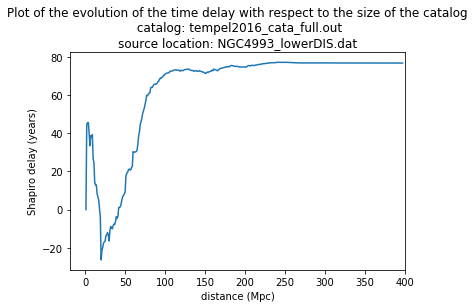

In [13]:
ShapiroVSradius = np.empty([0,2]) 
max_dis = int(np.max(cataDIS))

for dis in range(1,max_dis):
    cata_lim = cata_shapiro[np.logical_or.reduce([cata_shapiro[:,2] < dis])] # (days)
    cata_tot_Shapiro = np.sum(cata_lim[:,3]) # (days)
    ShapiroVSradius = np.insert(ShapiroVSradius,0,[dis,cata_tot_Shapiro/365.], axis = 0)

fig, ax = plt.subplots()
img = plt.plot(ShapiroVSradius[:,0],ShapiroVSradius[:,1]) 
plt.xlim(right=400)
plt.xlabel('distance (Mpc)')
plt.ylabel('Shapiro delay (years)')
plt.title('Plot of the evolution of the time delay with respect to the size of the catalog\n catalog: %s\nsource location: %s' % (catalog+'.out',position+'.dat'))
plt.savefig('gamma_outputs/Shapiro(size)_%s|%s.png' % (catalog,position), dpi= 200, bbox_inches="tight")
plt.show()